In [97]:
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

from math import sqrt
from sklearn.metrics import mean_squared_error

In [31]:
AirPax = pd.read_csv('AirPax.csv')
AirPax.tail()

,Year,Month,Pax
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390
143,1960,Dec,432


In [32]:
date_rng = pd.date_range(start='1/1/1949', end='31/12/1960', freq='M')
#date_rng

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

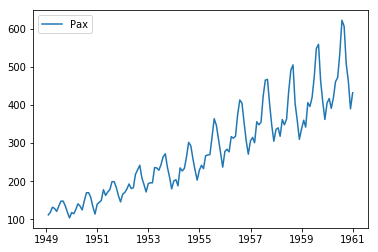

In [34]:
AirPax['TimeIndex'] = pd.DataFrame(date_rng, columns=['Month'])

plt.plot(AirPax.TimeIndex, AirPax.Pax)
plt.legend(loc='best')
#multiplicative

In [35]:
# extract out the time-series
pax_ts = AirPax['Pax']

In [36]:
dftest = adfuller(pax_ts)
dftest

(0.8153688792060423,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

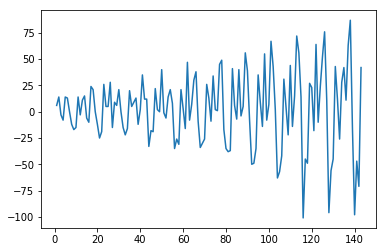

In [37]:
plt.plot(pax_ts.diff(periods=1))

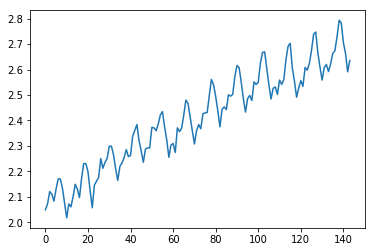

In [38]:
plt.plot(np.log10(pax_ts))

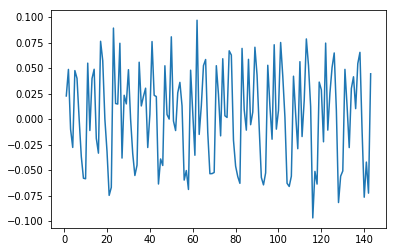

In [39]:
plt.plot(np.log10(pax_ts).diff(periods=1))

In [47]:
pax_ts_log = np.log10(pax_ts)
pax_ts_log1=pax_ts_log.dropna(inplace=True)


In [48]:
pax_ts_log_diff = pax_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
pax_ts_log_diff1 = pax_ts_log_diff.dropna(inplace=True)

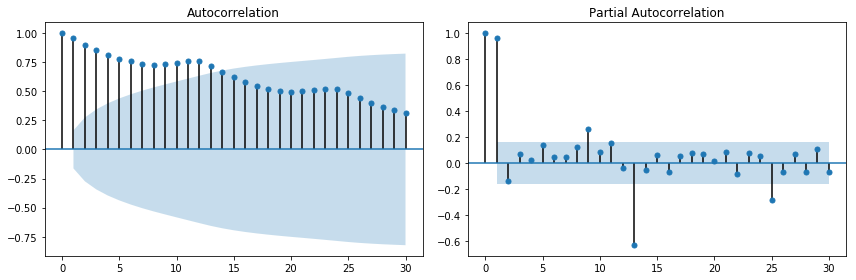

In [49]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(pax_ts_log, lags=30, ax=axes[0])
smt.graphics.plot_pacf(pax_ts_log, lags=30, ax=axes[1])
plt.tight_layout()

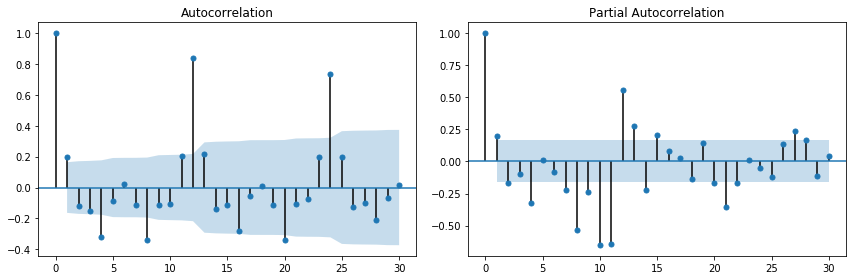

In [50]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(pax_ts_log_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(pax_ts_log_diff, lags=30, ax=axes[1])
plt.tight_layout()

In [83]:
dftest = adfuller(pax_ts.diff(periods=1)[1:,])
dftest

(-2.8292668241699874,
 0.05421329028382711,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854085)

In [82]:
dftest = adfuller(pax_ts_log_diff)
dftest

(-2.7171305983881444,
 0.07112054815085683,
 14,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 -653.8707758391575)

In [21]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [102]:
train=AirPax[0:120]
train1=train['Pax']
test=AirPax[120:]
train_pax_ts_log = np.log10(train['Pax'])

In [24]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [127]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_pax_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-603.9218059687751


## Predict sales on in-sample date using the best fit ARIMA model

In [128]:
best_model = sm.tsa.statespace.SARIMAX(train_pax_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True)
best_results = best_model.fit()

In [145]:
best_model= sm.tsa.statespace.SARIMAX(train1,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 1, 1, 12),
                                      enforce_stationarity=True)
best_results= best_model1.fit()

In [146]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                Pax   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -399.210
Date:                            Wed, 19 Dec 2018   AIC                            806.420
Time:                                    16:06:25   BIC                            817.111
Sample:                                         0   HQIC                           810.754
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2527      0.085     -2.960      0.003      -0.420      -0.085
ar.S.L12      -0.9980      0.381   

In [147]:
fcst_HoltW = test.copy()

In [148]:
fcst_HoltW['HoltWM']=best_results.forecast(len(test['Pax']))

In [149]:
#
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [150]:
mean_absolute_percentage_error(test['Pax'],fcst_HoltW['HoltWM'])

14.366837601826479

In [151]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test['Pax'],fcst_HoltW['HoltWM']))
rmse

72.05922385554567

In [152]:
best_model = sm.tsa.statespace.SARIMAX(pax_ts,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 1, 1, 12),
                                      enforce_stationarity=True)


In [153]:
total = best_model.fit()

In [154]:
total.forecast(24)

144    450.455292
145    425.641162
146    460.178510
147    499.276278
148    511.217959
149    569.440793
150    657.029766
151    642.277306
152    547.490199
153    497.972611
154    428.674554
155    472.147837
156    486.883324
157    460.956626
158    489.360715
159    531.181321
160    542.239529
161    604.944240
162    691.980646
163    676.057760
164    578.256356
165    531.100738
166    460.205939
167    502.297007
dtype: float64